## 基于python基础库，搭建卷积神经网络，并用该网络进行手写字符识别

#### 本程序主要基于python的numpy、math等基础函数库，完成了CNN训练的前向传播、后向传播、随机梯度下降更新等主要的函数功能；

#### 并基于该程序，在MNIST数据集上进行手写字符识别。

In [1]:
from __future__ import absolute_import,division,print_function

import gzip
import os
import time
import sys
import math
from six.moves import xrange
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 一些超参数设置

In [2]:
IMAGE_SIZE=28
NUM_CHANNELS=1 
PIXEL_DEPTH=255
BATCH_SIZE=64
NUM_LABELS=10
VAL_SIZE=64
MAX_EPOCHS = 2
SEED=2330
EVAL_FREQUENCY = 100
EVAL_BATCH_SIZE = 64

### 载入MNIST训练数据集，并将训练集划分出验证集

具体函数请参看`data_helper.py`文件

In [4]:
from data_helper import load_train,load_test

def onehot(targets, num):
    result = np.zeros((num, 10))
    for i in range(num):
        result[i][targets[i]] = 1
    return result

validation_size = 5000
train_data,train_labels,validation_data,validation_labels = load_train(validation_size,IMAGE_SIZE, NUM_CHANNELS, PIXEL_DEPTH)
test_data,test_labels = load_test(IMAGE_SIZE, NUM_CHANNELS, PIXEL_DEPTH)

train_labels = onehot(train_labels, 55000)
validation_labels = onehot(validation_labels, validation_size)
train_size = train_labels.shape[0]
print("train data size: ",len(train_data))
print("train data shape: ",train_data.shape)
print("train label shape: ",train_labels.shape)
print("test data shape: ", test_data.shape)
print("test label shape: ", test_labels.shape)


Extracting data,  ./data/train-images-idx3-ubyte.gz
Extracting labels, ./data/train-labels-idx1-ubyte.gz
Extracting data,  ./data/t10k-images-idx3-ubyte.gz
Extracting labels, ./data/t10k-labels-idx1-ubyte.gz
train data size:  55000
train data shape:  (55000, 28, 28, 1)
train label shape:  (55000, 10)
test data shape:  (10000, 28, 28, 1)
test label shape:  (10000,)


y is: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


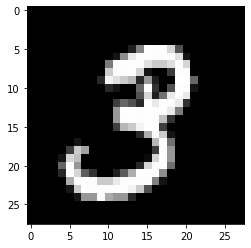

In [5]:
index = 1
plt.imshow(train_data[index].reshape((28,28)),cmap = plt.cm.gray)
print("y is: "+str(train_labels[index]))

### 设置输入层

### 卷积操作

In [6]:
class Convolution:
    def __init__(self, layer_shape, k_size=5, k_num=32, strides=1, seed=2330, padding='SAME'):
        self.input_shape = layer_shape
        self.input_batch = layer_shape[0]
        self.input_height = layer_shape[1]
        self.input_width = layer_shape[2]
        self.input_channels = layer_shape[3]
        
        self.seed = seed
        self.k_size = k_size
        self.strides = strides
        np.random.seed(self.seed)
        
        if (self.input_height-self.k_size) % self.strides != 0:
            print("input tensor height can\'t fit strides!")
        if (self.input_width-self.k_size) % self.strides != 0:
            print("input tensor width can\'t fit strides!")
        
        self.padding = padding
        if self.padding=='SAME':
            self.output_batch = self.input_batch
            self.output_height = self.input_height
            self.output_width = self.input_width
            self.output_channels = k_num
            self.delta = np.zeros((self.output_batch, self.output_height, self.output_width, self.output_channels))
        elif self.padding=='VALID':
            self.output_batch = self.input_batch
            self.output_height = (self.input_height-self.k_size) // self.strides + 1
            self.output_width = (self.input_width-self.k_size) // self.strides + 1
            self.output_channels = k_num
            self.delta = np.zeros((self.output_batch, self.output_height, self.output_width, self.output_channels))
        
        self.output_shape = self.delta.shape
        
        weights_scale = math.sqrt(k_size*k_size*self.output_channels/2) # init filter weights with dividing weights_scale 
        self.weights = np.random.standard_normal((k_size, k_size, self.input_channels, self.output_channels)) / weights_scale
        self.bias = np.random.standard_normal(self.output_channels) / weights_scale
        
        self.w_gradient = np.zeros(self.weights.shape)
        self.b_gradient = np.zeros(self.bias.shape)
        
    def img2col(self, image, ksize, stride):
        # image is a 4d tensor([batchsize, width ,height, channel])
        image_col = []
        for i in range(0, image.shape[1] - ksize + 1, stride):
            for j in range(0, image.shape[2] - ksize + 1, stride):
                col = image[:, i:i + ksize, j:j + ksize, :].reshape([-1])
                image_col.append(col)
        image_col = np.array(image_col)

        return image_col
        
        
    def forward(self,X):
        col_weights = self.weights.reshape([-1, self.output_channels])
        # padding
        if self.padding == 'SAME':
            X = np.pad(X, 
                ((0,0), (self.k_size//2,self.k_size//2), (self.k_size//2, self.k_size//2),(0,0)),
                'constant', constant_values=(0,0))
#         print(X.shape)
        # convolution 
        self.col_image = []
        conv_out = np.zeros(self.delta.shape)
        for i in range(self.input_batch):
            img_i = X[i][np.newaxis, :]
            self.col_image_i = self.img2col(img_i, self.k_size, self.strides)
            conv_out[i] = np.reshape(np.dot(self.col_image_i, col_weights) + self.bias, self.delta[0].shape)
            self.col_image.append(self.col_image_i)
        self.col_image = np.array(self.col_image)
        return conv_out
        
    
    def backward(self, delta, lr=0.0001, weight_decay=0.0004):
        self.delta = delta
        col_delta = np.reshape(delta, [self.input_batch, -1, self.output_channels])
        
        for i in range(self.input_batch):
            self.w_gradient += np.dot(self.col_image[i].T, col_delta[i]).reshape(self.weights.shape)
        self.b_gradient += np.sum(col_delta, axis=(0,1))
        
        if self.padding == 'SAME':
            pad_delta = np.pad(self.delta, 
                                ((0,0), (self.k_size//2,self.k_size//2), (self.k_size//2, self.k_size//2),(0,0)),
                                'constant', constant_values=(0,0))
        else:
            pad_delta = np.pad(self.delta, 
                                ((0, 0), (self.k_size - 1, self.k_size - 1), (self.k_size - 1, self.k_size - 1), (0, 0)),
                                'constant', constant_values=0)
            
        flip_weights = np.flipud(np.fliplr(self.weights))
        flip_weights = flip_weights.swapaxes(2, 3)
        col_flip_weights = flip_weights.reshape([-1, self.input_channels])
        col_pad_delta = np.array([self.img2col(pad_delta[i][np.newaxis, :], self.k_size, self.strides) for i in range(self.input_batch)])
        delta_back = np.dot(col_pad_delta, col_flip_weights)
        delta_back = np.reshape(delta_back, self.input_shape)
        
        # update weights
        self.weights = (1-weight_decay)*self.weights - lr*self.w_gradient
        self.bias = (1-weight_decay)*self.bias - lr*self.bias
        self.w_gradient = np.zeros(self.weights.shape)
        self.b_gradient = np.zeros(self.bias.shape)
        return delta_back

def test_():
    index = 1
    img = train_data[index:index+2, ...]
    y = train_labels[index:index+2,...]
    print("img.shape: \t", img.shape)
    
    conv = Convolution(img.shape, k_size=3, k_num=2, strides=1, seed=2330, padding='VALID')
    conv_out = conv.forward(img)
    print("conv_out.shape: ", conv_out.shape)

    
    conv_back = conv.backward(conv_out, lr=0.0001)
    print("conv_back.shape:", conv_back.shape)
    
test_()

img.shape: 	 (2, 28, 28, 1)
conv_out.shape:  (2, 26, 26, 2)
conv_back.shape: (2, 28, 28, 1)


### ReLu 层

In [7]:
# rule Activator
class Relu:  
    def __init__(self, input_shape):
        self.delta = np.zeros(input_shape)
        self.input_shape = input_shape
        self.output_shape = self.input_shape
        
    def forward(self, x):
        self.x = x
        return np.maximum(x, 0)
    
    def backward(self, delta):
        delta[self.x<0] = 0
        return delta
    
def test_():
    index = 1
    img = train_data[index:index+2, ...]
    y = train_labels[index:index+2,...]
    print("img.shape: \t", img.shape)
    
    conv = Convolution(img.shape, k_size=3, k_num=2, strides=1, seed=2330, padding='VALID')
    conv_out = conv.forward(img)
    print("conv_out.shape: ", conv_out.shape)

    relu=Relu(conv_out.shape)
    relu_out = relu.forward(conv_out)
    print("relu_out.shape: ", relu_out.shape)
    
    relu_back = relu.backward(relu_out)
    print("relu_back.shape:", relu_back.shape)
    
    conv_back = conv.backward(relu_back, lr=0.0001)
    print("conv_back.shape:", conv_back.shape)
    
test_()

img.shape: 	 (2, 28, 28, 1)
conv_out.shape:  (2, 26, 26, 2)
relu_out.shape:  (2, 26, 26, 2)
relu_back.shape: (2, 26, 26, 2)
conv_back.shape: (2, 28, 28, 1)


### max_pooling 层

In [8]:
class max_pool:
    def __init__(self, input_shape, k_size=2, strides=2):
        self.input_shape = input_shape
        self.k_size = k_size
        self.strides = strides
        self.output_shape = [input_shape[0], input_shape[1] // self.strides, input_shape[2] // self.strides, input_shape[3]]
    
    def forward(self, x):
        b, w, h, c = x.shape
        feature_w = w // self.strides
        feature = np.zeros((b, feature_w, feature_w, c))
        self.feature_mask = np.zeros((b, w, h, c))   # 记录最大池化时最大值的位置信息用于反向传播
        for bi in range(b):
            for ci in range(c):
                for i in range(0,h,self.strides):
                    for j in range(0,w, self.strides):
                        feature[bi, i//self.strides, j//self.strides, ci] = np.max(
                            x[bi,i:i+self.k_size,j:j+self.k_size,ci])
                        index = np.argmax(x[bi, i:i+self.k_size, j:j+self.k_size,ci])
                        self.feature_mask[bi, i+index//self.strides, j+index%self.strides, ci] = 1                    
        return feature

    def backward(self, delta):
        return np.repeat(np.repeat(delta, self.strides, axis=1), self.strides, axis=2) * self.feature_mask
    
def test_():
    index = 1
    img = train_data[index:index+2, ...]
    y = train_labels[index:index+2,...]
    print("img.shape: \t", img.shape)
    
    conv = Convolution(img.shape, k_size=3, k_num=2, strides=1, seed=2330, padding='VALID')
    conv_out = conv.forward(img)
    print("conv_out.shape: ", conv_out.shape)

    relu=Relu(conv_out.shape)
    relu_out = relu.forward(conv_out)
    print("relu_out.shape: ", relu_out.shape)
    
    pool = max_pool(relu_out.shape,2,2)
    pool_out = pool.forward(relu_out)
    print("pool_out.shape: ", pool_out.shape)
    
    pool_back = pool.backward(pool_out)
    print("pool_back.shape:", pool_back.shape)
    
    relu_back = relu.backward(pool_back)
    print("relu_back.shape:", relu_back.shape)
    
    conv_back = conv.backward(relu_back, lr=0.0001)
    print("conv_back.shape:", conv_back.shape)
    
test_()
    

img.shape: 	 (2, 28, 28, 1)
conv_out.shape:  (2, 26, 26, 2)
relu_out.shape:  (2, 26, 26, 2)
pool_out.shape:  (2, 13, 13, 2)
pool_back.shape: (2, 26, 26, 2)
relu_back.shape: (2, 26, 26, 2)
conv_back.shape: (2, 28, 28, 1)


In [9]:
class flatten:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.output_shape = [self.input_shape[0], self.input_shape[1] * self.input_shape[2] * self.input_shape[3]]
        
    def forward(self, x):
        y = x.reshape([self.input_shape[0], self.input_shape[1] * self.input_shape[2] * self.input_shape[3]])
        return y
    def backward(self, y):
        x = np.reshape(y, [self.input_shape[0], self.input_shape[1], self.input_shape[2], self.input_shape[3]])
        return x

def test_():
    index = 1
    img = train_data[index:index+2, ...]
    y = train_labels[index:index+2,...]
    print("img.shape: \t", img.shape)
    
    conv = Convolution(img.shape, k_size=3, k_num=2, strides=1, seed=2330, padding='SAME')
    conv_out = conv.forward(img)
    print("conv_out.shape: ", conv_out.shape)

    relu=Relu(conv.output_shape)
    relu_out = relu.forward(conv_out)
    print("relu_out.shape: ", relu_out.shape)
    
    pool = max_pool(relu.output_shape,2,2)
    pool_out = pool.forward(relu_out)
    print("pool_out.shape: ", pool_out.shape)
    
    flat = flatten(pool.output_shape)
    flat_out = flat.forward(pool_out)
    print("flat_out.shape: ", flat_out.shape)
    
    flat_back = flat.backward(flat_out)
    print("flat_back.shape:", flat_back.shape)
    
    pool_back = pool.backward(flat_back)
    print("pool_back.shape:", pool_back.shape)
    
    relu_back = relu.backward(pool_back)
    print("relu_back.shape:", relu_back.shape)
    
    conv_back = conv.backward(relu_back, lr=0.0001)
    print("conv_back.shape:", conv_back.shape)
    
test_()

img.shape: 	 (2, 28, 28, 1)
conv_out.shape:  (2, 28, 28, 2)
relu_out.shape:  (2, 28, 28, 2)
pool_out.shape:  (2, 14, 14, 2)
flat_out.shape:  (2, 392)
flat_back.shape: (2, 14, 14, 2)
pool_back.shape: (2, 28, 28, 2)
relu_back.shape: (2, 28, 28, 2)
conv_back.shape: (2, 28, 28, 1)


### 全连接层


In [10]:
class full_connection:
    def __init__(self, input_shape, output_channels, seed=2330):
        self.input_shape = input_shape
        self.input_batch = input_shape[0]
        self.input_length = input_shape[1]
        self.output_channels = output_channels
        
        self.seed = seed
        np.random.seed(self.seed)
        
        weights_scale = math.sqrt(self.input_length/2) 
        self.weights = np.random.standard_normal((self.input_length,self.output_channels)) / weights_scale
        self.bias = np.random.standard_normal(self.output_channels) / weights_scale
        
        self.output_shape = [self.input_batch, self.output_channels]
        self.w_gradient = np.zeros(self.weights.shape)
        self.b_gradient = np.zeros(self.bias.shape)
        
    def forward(self, x):
        self.x = x
        y = np.dot(self.x, self.weights) +self.bias
        return y
    
    def backward(self, delta, lr=0.0001, weight_decay=0.0004):
        delta_back = np.dot(delta, self.weights.T)
        self.w_gradient = np.dot(self.x.T, delta)
        self.b_gradient = np.sum(delta, axis=0)
        
        self.weights = (1-weight_decay)*self.weights - lr*self.w_gradient
        self.bias = (1-weight_decay)*self.bias - lr*self.bias
        
        self.w_gradient = np.zeros(self.weights.shape)
        self.b_gradient = np.zeros(self.bias.shape)
        return delta_back
    
def test_():
    index = 1
    img = train_data[index:index+2, ...]
    y = train_labels[index:index+2,...]
    print("img.shape: \t", img.shape)
    
    conv = Convolution(img.shape, k_size=3, k_num=2, strides=1, seed=2330, padding='SAME')
    conv_out = conv.forward(img)
    print("conv_out.shape: ", conv_out.shape)

    relu=Relu(conv.output_shape)
    relu_out = relu.forward(conv_out)
    print("relu_out.shape: ", relu_out.shape)
    
    pool = max_pool(relu.output_shape,2,2)
    pool_out = pool.forward(relu_out)
    print("pool_out.shape: ", pool_out.shape)
    
    flat = flatten(pool.output_shape)
    flat_out = flat.forward(pool_out)
    print("flat_out.shape: ", flat_out.shape)
    
    fc = full_connection(flat.output_shape,10,seed=SEED)
    fc_out = fc.forward(flat_out)
    print("fc_out.shape: \t", fc_out.shape)
    
    fc_back = fc.backward(fc_out,lr=0.0001)
    print("fc_back.shape: \t",fc_back.shape)
    
    flat_back = flat.backward(fc_back)
    print("flat_back.shape:", flat_back.shape)
    
    pool_back = pool.backward(flat_back)
    print("pool_back.shape:", pool_back.shape)
    
    relu_back = relu.backward(pool_back)
    print("relu_back.shape:", relu_back.shape)
    
    conv_back = conv.backward(relu_back, lr=0.0001)
    print("conv_back.shape:", conv_back.shape)
    
test_()

img.shape: 	 (2, 28, 28, 1)
conv_out.shape:  (2, 28, 28, 2)
relu_out.shape:  (2, 28, 28, 2)
pool_out.shape:  (2, 14, 14, 2)
flat_out.shape:  (2, 392)
fc_out.shape: 	 (2, 10)
fc_back.shape: 	 (2, 392)
flat_back.shape: (2, 14, 14, 2)
pool_back.shape: (2, 28, 28, 2)
relu_back.shape: (2, 28, 28, 2)
conv_back.shape: (2, 28, 28, 1)


### Softmax 层

In [11]:
class Softmax:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.input_batch = input_shape[0]
        self.class_num = input_shape[1]
        
        self.softmax = np.zeros(self.input_shape)
        self.delta = np.zeros(self.input_shape)
        
    def cal_loss(self, x, label):
        self.prediction(x)
        loss = 0
        for i in range(self.input_batch):
            loss -= np.sum(np.log(self.softmax[i]) * label[i])
        loss /= self.input_batch
        return loss
    
    def prediction(self, x):
        for i in range(self.input_batch):
            pred_tmp = x[i, :] - np.max(x[i, :])
            pred_tmp = np.exp(pred_tmp)
            self.softmax[i] = pred_tmp/np.sum(pred_tmp)
        return self.softmax
    
    def backward(self, label):
        for i in range(self.input_batch):
            self.delta[i] = self.softmax[i] - label[i]
        return self.delta
    
def test_():
    index = 1
    img = train_data[index:index+2, ...]
    y = train_labels[index:index+2,...]
    print("img.shape: \t", img.shape)
    
    conv = Convolution(img.shape, k_size=5, k_num=32, strides=1, seed=2330, padding='SAME')
    conv_out = conv.forward(img)
    print("conv_out.shape: ", conv_out.shape)

    relu=Relu(conv.output_shape)
    relu_out = relu.forward(conv_out)
    print("relu_out.shape: ", relu_out.shape)
    
    pool = max_pool(relu.output_shape,2,2)
    pool_out = pool.forward(relu_out)
    print("pool_out.shape: ", pool_out.shape)
    
    flat = flatten(pool.output_shape)
    flat_out = flat.forward(pool_out)
    print("flat_out.shape: ", flat_out.shape)
    
    fc = full_connection(flat.output_shape,10,seed=SEED)
    fc_out = fc.forward(flat_out)
    print("fc_out.shape: \t", fc_out.shape)
    
    softmax = Softmax(fc.output_shape)
    
    pred = softmax.prediction(fc_out)
    print("pred.shape: \t", pred.shape)
    
    loss = softmax.cal_loss(fc_out, y)
    print("loss:  \t\t", loss)
    
    loss_back = softmax.backward(label=y)
    print("loss_back.shape:", loss_back.shape)
    
    fc_back = fc.backward(loss_back,lr=0.0001)
    print("fc_back.shape: \t",fc_back.shape)
    
    flat_back = flat.backward(fc_back)
    print("flat_back.shape:", flat_back.shape)
    
    pool_back = pool.backward(flat_back)
    print("pool_back.shape:", pool_back.shape)
    
    relu_back = relu.backward(pool_back)
    print("relu_back.shape:", relu_back.shape)
    
    conv_back = conv.backward(relu_back, lr=0.0001)
    print("conv_back.shape:", conv_back.shape)
    
    
test_()

img.shape: 	 (2, 28, 28, 1)
conv_out.shape:  (2, 28, 28, 32)
relu_out.shape:  (2, 28, 28, 32)
pool_out.shape:  (2, 14, 14, 32)
flat_out.shape:  (2, 6272)
fc_out.shape: 	 (2, 10)
pred.shape: 	 (2, 10)
loss:  		 2.320875261985801
loss_back.shape: (2, 10)
fc_back.shape: 	 (2, 6272)
flat_back.shape: (2, 14, 14, 32)
pool_back.shape: (2, 28, 28, 32)
relu_back.shape: (2, 28, 28, 32)
conv_back.shape: (2, 28, 28, 1)


### 搭建CNN网络

In [12]:
class CNN:
    def __init__(self,num_labels=10, batch_size=64, image_size=28, num_channels=1, seed=66478):
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_channels = num_channels
        self.seed = seed
        self.num_labels=num_labels
        self.net_builder()
        
    def net_builder(self):
        self.conv1 = Convolution([self.batch_size, self.image_size, self.image_size, self.num_channels], k_size=5, k_num=6, strides=1, seed=2330, padding='VALID')
        self.relu1 = Relu(self.conv1.output_shape)
        self.pool1 = max_pool(self.relu1.output_shape, 2,2)
            
        self.conv2 = Convolution(self.pool1.output_shape, k_size=5, k_num=16, strides=1, seed=2330, padding='VALID')
        self.relu2 = Relu(self.conv2.output_shape)
        self.pool2 = max_pool(self.relu2.output_shape, 2,2)
            
        self.flat = flatten(self.pool2.output_shape)
        self.fc1 = full_connection(self.flat.output_shape,512,seed=SEED)
        self.relu3 = Relu(self.fc1.output_shape)
            
        self.fc2 = full_connection(self.relu3.output_shape,10,seed=SEED)
            
        self.softmax = Softmax(self.fc2.output_shape)
        
    def cal_forward(self,x):
        conv1_out = self.conv1.forward(x)
        relu1_out = self.relu1.forward(conv1_out)
        pool1_out = self.pool1.forward(relu1_out)
        
        conv2_out = self.conv2.forward(pool1_out)
        relu2_out = self.relu2.forward(conv2_out)
        pool2_out = self.pool2.forward(relu2_out)
        
        flat_out = self.flat.forward(pool2_out)
        fc1_out = self.fc1.forward(flat_out)
        relu3_out = self.relu3.forward(fc1_out)
        
        fc2_out = self.fc2.forward(relu3_out)

        pred = self.softmax.prediction(fc2_out)
        return np.argmax(pred,axis=1)

    def fit(self, x, y, lr):
        conv1_out = self.conv1.forward(x)
        relu1_out = self.relu1.forward(conv1_out)
        pool1_out = self.pool1.forward(relu1_out)
        
        conv2_out = self.conv2.forward(pool1_out)
        relu2_out = self.relu2.forward(conv2_out)
        pool2_out = self.pool2.forward(relu2_out)
        
        flat_out = self.flat.forward(pool2_out)
        fc1_out = self.fc1.forward(flat_out)
        relu3_out = self.relu3.forward(fc1_out)
        
        fc2_out = self.fc2.forward(relu3_out)

        pred = self.softmax.prediction(fc2_out)
        loss = self.softmax.cal_loss(fc2_out, y)
        
        loss_back = self.softmax.backward(label=y)
        fc2_back = self.fc2.backward(loss_back, lr=lr)
        relu3_back = self.relu3.backward(fc2_back)
        fc1_back = self.fc1.backward(relu3_back, lr=lr)
        flat_back = self.flat.backward(fc1_back)
        poo2_back = self.pool2.backward(flat_back)
        relu2_back = self.relu2.backward(poo2_back)
        conv2_back = self.conv2.backward(relu2_back)
        pool1_back = self.pool1.backward(conv2_back)
        relu1_back = self.relu1.backward(pool1_back)
        conv1__back = self.conv1.backward(relu1_back)
        return loss, np.argmax(pred,axis=1)


### 定义辅助函数

In [13]:
# calculate accuracy
def cal_acc(predictions, labels):
    return (100.0 * np.sum(predictions == labels) /predictions.shape[0]) 

def eval_in_batches(data,cnn):
    size = data.shape[0]
    if size < EVAL_BATCH_SIZE:
        raise ValueError("batch size for evals larger than dataset: %d" % size)
    predictions = np.zeros(size)
    for begin in xrange(0, size, EVAL_BATCH_SIZE):
        end = begin + EVAL_BATCH_SIZE
        if end <= size:
            x = data[begin:end, ...]
            predictions[begin:end] = cnn.cal_forward(x)
        else:
            x = data[-EVAL_BATCH_SIZE:, ...]
            batch_predictions = cnn.cal_forward(x)
            predictions[begin:] = batch_predictions[begin - size:]
    return predictions


### 训练过程

In [15]:
cnn = CNN(num_labels=10, batch_size=64, image_size=28, num_channels=1, seed=SEED)
learning_rate = 0.01

start_time = time.time()
for step in xrange(int(MAX_EPOCHS * train_size) // BATCH_SIZE):
    offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
    batch_x = train_data[offset:(offset + BATCH_SIZE), ...]
    batch_y = train_labels[offset:(offset + BATCH_SIZE)]

    loss, predictions = cnn.fit(batch_x,batch_y,learning_rate)
#     acc = cal_acc(predictions, np.argmax(batch_y, axis=1))
#     print('Step %d (epoch %.2f)' % (step, float(step) * BATCH_SIZE / train_size))
#     print('Minibatch loss: %.3f' % loss)
#     print('Minibatch acc:  %.1f%%' % acc)
    
    if step % EVAL_FREQUENCY == 0:
        acc = cal_acc(predictions, np.argmax(batch_y, axis=1))
        print('Step %d (epoch %.2f)' % (step, float(step) * BATCH_SIZE / train_size))
        print('Minibatch loss: %.3f' % loss)
        print('Minibatch acc:  %.1f%%' % acc)
        val_predictions = eval_in_batches(validation_data[0:1000, ...],cnn)
        val_acc = cal_acc(val_predictions, np.argmax(validation_labels[0:1000], axis=1))
        print('Validation error: %.1f%%' % val_acc)
 

Step 0 (epoch 0.00)
Minibatch loss: 2.387
Minibatch acc:  9.4%
Validation error: 8.7%
Step 50 (epoch 0.06)
Minibatch loss: 0.761
Minibatch acc:  79.7%
Validation error: 81.0%
Step 100 (epoch 0.12)
Minibatch loss: 0.253
Minibatch acc:  92.2%
Validation error: 89.1%
Step 150 (epoch 0.17)
Minibatch loss: 0.436
Minibatch acc:  81.2%
Validation error: 85.4%
Step 200 (epoch 0.23)
Minibatch loss: 0.328
Minibatch acc:  92.2%
Validation error: 92.2%
Step 250 (epoch 0.29)
Minibatch loss: 0.175
Minibatch acc:  95.3%
Validation error: 94.3%
Step 300 (epoch 0.35)
Minibatch loss: 0.211
Minibatch acc:  92.2%
Validation error: 93.9%
Step 350 (epoch 0.41)
Minibatch loss: 0.122
Minibatch acc:  98.4%
Validation error: 94.9%
Step 400 (epoch 0.47)
Minibatch loss: 0.307
Minibatch acc:  90.6%
Validation error: 95.2%
Step 450 (epoch 0.52)
Minibatch loss: 0.125
Minibatch acc:  96.9%
Validation error: 94.5%
Step 500 (epoch 0.58)
Minibatch loss: 0.255
Minibatch acc:  92.2%
Validation error: 94.2%
Step 550 (epoch

### 测试过程，输出测试集准确率

In [16]:
test_predictions = eval_in_batches(test_data, cnn)
test_acc = cal_acc(test_predictions, test_labels)
print("test data acc: %.1f%%" % test_acc)

test data acc: 97.7%


### Reference

- [https://zhuanlan.zhihu.com/c_162633442](https://zhuanlan.zhihu.com/c_162633442)
- [https://www.cnblogs.com/qxcheng/p/11729773.html](https://www.cnblogs.com/qxcheng/p/11729773.html)
